In [ ]:
!unzip /content/drive/MyDrive/MECH_NOISE/AUDIO-DATASET-PROCESSED/MECH-DATA.zip

# ***0. DEPENDENCE***

In [157]:
import numpy as np
import pandas as pd
import math


import os
import shutil
import glob

import librosa
import soundfile
from IPython.display import Audio, display


import random
from tqdm import tqdm
import zipfile

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras
from keras import backend as K


from keras.models import Model, Sequential
from keras.layers import Input, Conv1D, Lambda, Dense, Flatten, MaxPooling1D,Dropout, Layer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Mean, CosineSimilarity
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy

# ***1. DATA PREPARE***

## ***1.1. PLAY SOUND***

In [ ]:
def play_sound(audio):
    audio = np.reshape(audio, newshape=(8820,))
    audio_widget = Audio(audio, rate=44100)
    display(audio_widget)

## ***1.2. GET TRIPLETS***

In [73]:
def get_triplets(DATASET, max_triplets=4):
    if not os.path.isdir(DATASET):
        raise "DATASET PATH ERROR"

    positive_folder = os.path.join(DATASET, "OK")
    negative_folder = os.path.join(DATASET, "NG")

    if not os.path.isdir(positive_folder) or not os.path.isdir(negative_folder):
        raise "FOLDER NAME ERROR"

    anchor_sounds = []
    positive_sounds = []
    negative_sounds = []

    pos_sounds = [os.path.join(positive_folder, sound) for sound in os.listdir(positive_folder)]
    neg_sounds = [os.path.join(negative_folder, sound) for sound in os.listdir(negative_folder)]

    for _ in range(3):
        random.shuffle(pos_sounds)

    for _ in range(len(pos_sounds)):
        anchor_sound = random.choice(pos_sounds)

        store = []
        for _ in range(max_triplets):
            positive_sound = random.choice([sound for sound in pos_sounds if sound != anchor_sound and sound not in store])
            negative_sound = random.choice([sound for sound in neg_sounds if sound not in store])

            anchor_sounds.append(anchor_sound)
            positive_sounds.append(positive_sound)
            negative_sounds.append(negative_sound)

            store.extend([positive_sound, negative_sound])
    triplets = list(zip(anchor_sounds, positive_sounds, negative_sounds))
    return triplets

DATASET = "/content/MECH-DATA/TRAIN"

triplets = get_triplets(DATASET)
for anchors, positives, negatives in triplets[:10]:
    print("\n{:<55s}\t{:<55s}\t{:<55s}".format(str(anchors), str(positives), str(negatives)))


/content/MECH-DATA/TRAIN/OK/OKVAL_LAN2_28.wav          	/content/MECH-DATA/TRAIN/OK/OKTRAIN_LAN1_12.wav        	/content/MECH-DATA/TRAIN/NG/NG_LOAI3_LAN2_50.wav       

/content/MECH-DATA/TRAIN/OK/OKVAL_LAN2_28.wav          	/content/MECH-DATA/TRAIN/OK/OKTRAIN_LAN2_31.wav        	/content/MECH-DATA/TRAIN/NG/NG_LOAI3_LAN2_39.wav       

/content/MECH-DATA/TRAIN/OK/OKVAL_LAN2_28.wav          	/content/MECH-DATA/TRAIN/OK/OKTRAIN_LAN2_82.wav        	/content/MECH-DATA/TRAIN/NG/NG_LOAI1_5.wav             

/content/MECH-DATA/TRAIN/OK/OKVAL_LAN2_28.wav          	/content/MECH-DATA/TRAIN/OK/OKTRAIN_LAN1_13.wav        	/content/MECH-DATA/TRAIN/NG/NG_LOAI1_16.wav            

/content/MECH-DATA/TRAIN/OK/OKTRAIN_LAN2_48.wav        	/content/MECH-DATA/TRAIN/OK/OKTRAIN_LAN2_4.wav         	/content/MECH-DATA/TRAIN/NG/NG_LOAI3_LAN1_25.wav       

/content/MECH-DATA/TRAIN/OK/OKTRAIN_LAN2_48.wav        	/content/MECH-DATA/TRAIN/OK/OKTRAIN_LAN1_65.wav        	/content/MECH-DATA/TRAIN/NG/NG_LOAI3_LAN1_

## ***1.3. SPLIT TRIPLETS***

In [74]:
def split_triplets(triplets):
    train_triplets, val_triplets = train_test_split(triplets, test_size=0.33, shuffle=True)
    val_triplets, test_triplets = train_test_split(val_triplets, test_size=0.33, shuffle=True)
    return train_triplets, val_triplets, test_triplets

In [75]:
train_triplets, val_triplets, test_triplets = split_triplets(triplets)
len(train_triplets), len(val_triplets), len(test_triplets)

(755, 249, 124)

## ***1.4. LOAD & PREPROCESS AUDIO***

In [76]:
def load_and_preprocess_audio(audio_path, expand_dims=True):
    audio, sample_rate = librosa.load(audio_path, sr=None)
    audio = audio[int(sample_rate*0.3):int(sample_rate*0.5)]
    if expand_dims:
        audio = np.expand_dims(audio, axis=-1)
    return audio

## ***1.5. BATCH GENERATOR***

In [77]:
def batch_generator(triplets, batch_size=32):
    total_triplets = len(triplets)
    random_indices = list(range(total_triplets))
    random.shuffle(random_indices)


    for i in range(0, total_triplets, batch_size):
        batch_indices = random_indices[i:i + batch_size]
        batch_triplets = [triplets[j] for j in batch_indices]

        anchor_batch = []
        positive_batch = []
        negative_batch = []

        for triplet in batch_triplets:
            anchor, positive, negative = triplet

            anchor_image = load_and_preprocess_audio(anchor)
            positive_image = load_and_preprocess_audio(positive)
            negative_image = load_and_preprocess_audio(negative)

            anchor_batch.append(anchor_image)
            positive_batch.append(positive_image)
            negative_batch.append(negative_image)

        yield [np.array(anchor_batch),
               np.array(positive_batch),
               np.array(negative_batch)]

## ***1.6. VISUALIZE TRIPLETS***

In [78]:
def visualize_triplets(triplets):
    anchor_batch, positive_batch, negative_batch = triplets

    for i in range(len(anchor_batch)):
        plt.figure(figsize=(12, 5))
        play_sound(anchor_batch[i])
        plt.subplot(1, 3, 1)
        plt.title("Anchor")

        plt.plot(anchor_batch[i])
        # plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Positive")
        play_sound(positive_batch[i])
        plt.plot(positive_batch[i])
        # plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Negative")
        play_sound(negative_batch[i])
        plt.plot(negative_batch[i])
        # plt.axis('off')

        plt.show()
        print()

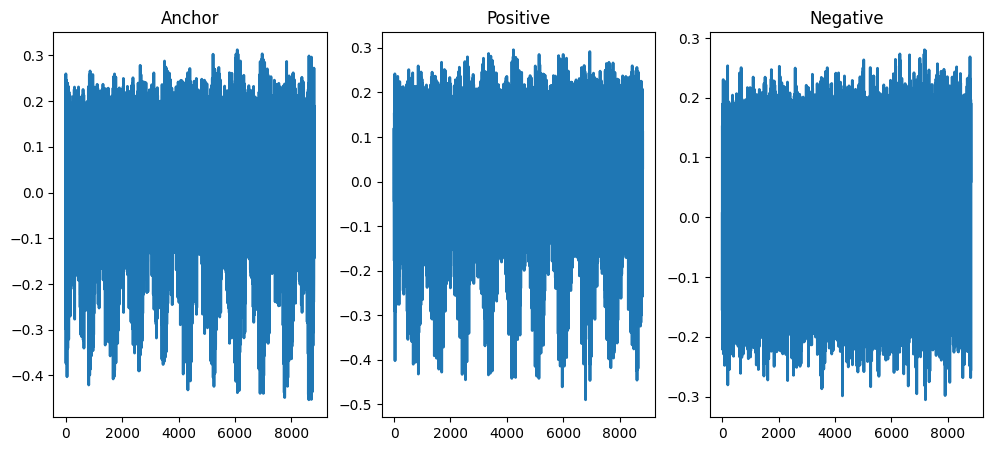

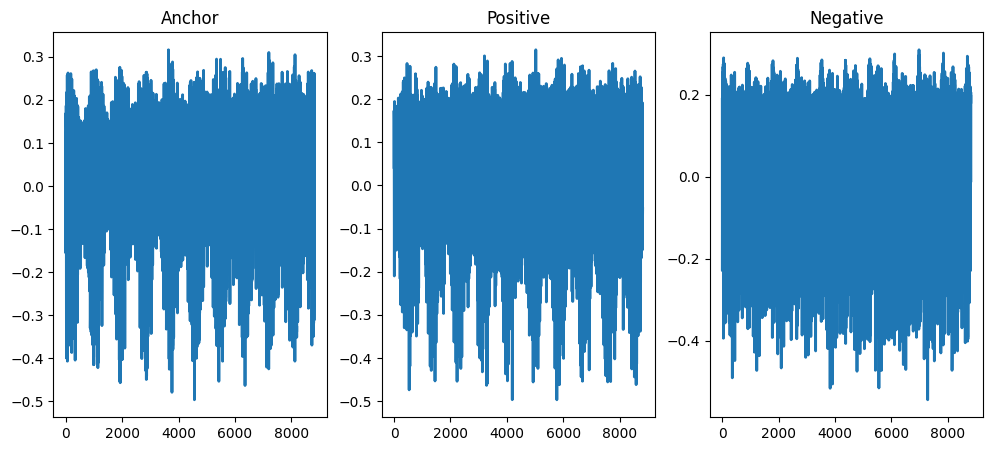

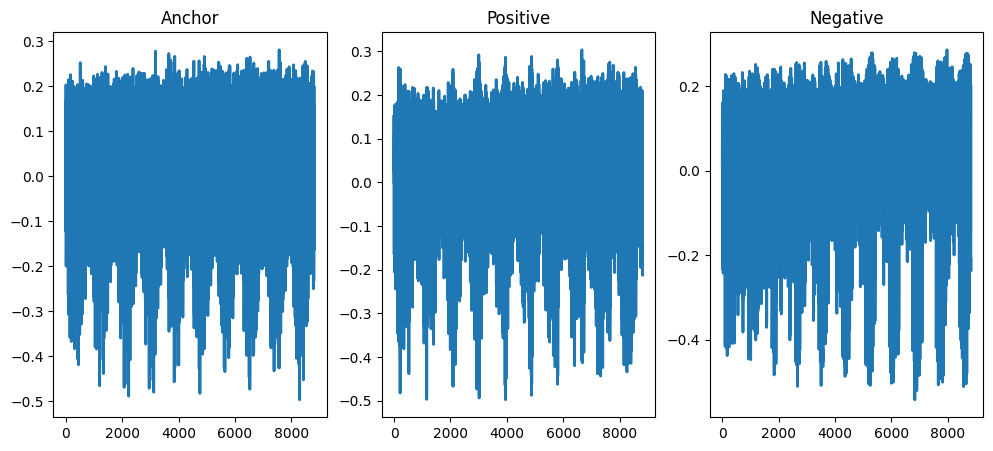

In [79]:
example_triplets = [next(batch_generator(train_triplets, 3))]
visualize_triplets(example_triplets[0])

# ***2. MODEL WDCNN***

In [80]:
def WDCNN(input_shape =(8820,1)):

    model = Sequential()

    # WDCNN
    model.add(Conv1D(filters=16, kernel_size=32, strides=16, activation='relu', padding='same',input_shape=input_shape))
    model.add(MaxPooling1D(strides=2))
    model.add(Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPooling1D(strides=2))
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, activation='relu', padding='same'))
    model.add(MaxPooling1D(strides=2))
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPooling1D(strides=2))
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, activation='relu'))
    model.add(MaxPooling1D(strides=2))
    model.add(Flatten())
    model.add(Dense(100,activation='sigmoid'))
    return model

## ***2.1. DISTANCE LAYER***

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor (InputLayer)         [(None, 8820, 1)]            0         []                            
                                                                                                  
 positive (InputLayer)       [(None, 8820, 1)]            0         []                            
                                                                                                  
 negative (InputLayer)       [(None, 8820, 1)]            0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 100)                  133460    ['anchor[0][0]',              
                                                                     'positive[0][0]',      

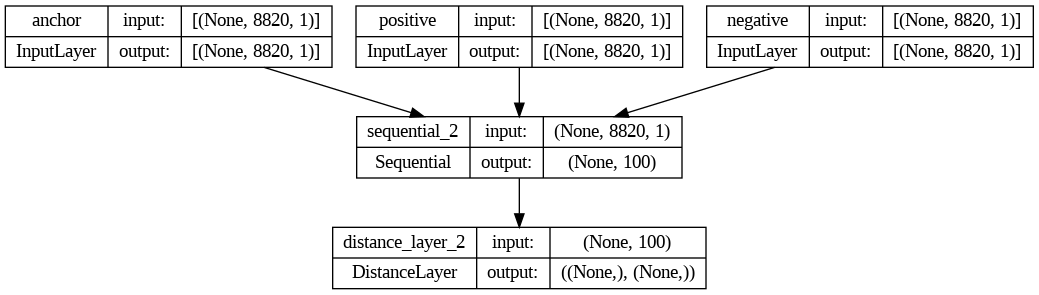

In [81]:
@keras.saving.register_keras_serializable()
class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return ap_distance, an_distance

input_shape = (8820, 1)

anchor_input = Input(name='anchor', shape=input_shape)
positive_input = Input(name='positive', shape=input_shape)
negative_input = Input(name='negative', shape=input_shape)

embedding = WDCNN()
distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input)
)

siamese_net = Model(
    inputs=[anchor_input,
            positive_input,
            negative_input],
    outputs=distances
)

print(siamese_net.summary())
plot_model(siamese_net, show_shapes=True, show_layer_names=True)


# ***3. TRAIN MODEL***

In [83]:
@tf.keras.saving.register_keras_serializable()
class SiameseModel(Model):
    def __init__(self, siamese_net, margin=5):
        super().__init__()
        self.siamese_net = siamese_net
        self.margin = margin
        self.loss_tracker = Mean(name='loss')
        self.accuracy_tracker = Mean(name='accuracy')

    def call(self, inputs):
        return self.siamese_net(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_net.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_net.trainable_weights)
        )

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_net(data)

        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, .0)
        return loss

    def _compute_accuracy(self, data):
        ap_distance, an_distance = self.siamese_net(data)
        accuracy = tf.reduce_mean(tf.cast(ap_distance < an_distance,
                                          tf.float32))
        return accuracy

    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

    def get_config(self):
        base_config = super().get_config()
        config = {
            'siamese_net': tf.keras.saving.serialize_keras_object(self.siamese_net),
            'margin': tf.keras.saving.serialize_keras_object(self.margin),
            'loss_tracker': tf.keras.saving.serialize_keras_object(self.loss_tracker),
            'accuracy_tracker': tf.keras.saving.serialize_keras_object(self.accuracy_tracker),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        config['siamese_net'] = tf.keras.saving.deserialize_keras_object(config.pop('siamese_net'))
        config['margin'] = tf.keras.saving.deserialize_keras_object(config.pop('margin'))
        config['loss_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('loss_tracker'))
        config['accuracy_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('accuracy_tracker'))
        return cls(**config)

In [84]:
def train_model(model,
                train_triplets,
                epochs,
                batch_size,
                val_triplets,
                patience,
                delta=0.0001):

    best_val_accuracy = 0
    best_val_loss = float('inf')
    temp_patience = patience
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }

    train_steps_per_epoch = math.ceil(len(train_triplets) / batch_size)
    val_steps_per_epoch = math.ceil(len(val_triplets) / batch_size)

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        train_loss = 0.
        train_accuracy = 0.
        val_loss = 0.
        val_accuracy = 0.

        with tqdm(total=train_steps_per_epoch, desc='Training') as pbar:
            for batch in batch_generator(train_triplets, batch_size=batch_size):
                loss, accuracy = model.train_on_batch(batch)
                train_loss += loss
                train_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        with tqdm(total=val_steps_per_epoch, desc='Validation') as pbar:
            for batch in batch_generator(val_triplets, batch_size=batch_size):
                loss, accuracy = model.test_on_batch(batch)
                val_loss += loss
                val_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        train_loss /= train_steps_per_epoch
        train_accuracy /= train_steps_per_epoch
        val_loss /= val_steps_per_epoch
        val_accuracy /= val_steps_per_epoch

        history['loss'].append(train_loss)
        history['accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'\nTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            model.layers[0].layers[3].save_weights('best_model.weights.h5')

        if val_loss - best_val_loss > delta:
            temp_patience -= 1
            if temp_patience == 0:
                print('Early stopping: Validation loss did not improve.')
                break
        else:
            best_val_loss = val_loss
            temp_patience = patience

    return model, history

In [85]:
siamese_model = SiameseModel(siamese_net)
siamese_model.compile(optimizer=Adam(0.001))

siamese_model, history = train_model(siamese_model,
                                     train_triplets=train_triplets,
                                     epochs=30,
                                     batch_size=128,
                                     val_triplets=val_triplets,
                                     patience=5)

Epoch 1/30


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, Loss=4.95, Accuracy=0.992]



Train Loss: 4.9933, Train Accuracy: 0.9399
Validation Loss: 4.9527, Validation Accuracy: 0.9802

Epoch 2/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.23it/s, Loss=3.92, Accuracy=1]



Train Loss: 4.7390, Train Accuracy: 0.9450
Validation Loss: 3.9087, Validation Accuracy: 0.9844

Epoch 3/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.44it/s, Loss=0.961, Accuracy=0.983]



Train Loss: 2.7448, Train Accuracy: 0.9297
Validation Loss: 1.1183, Validation Accuracy: 0.9605

Epoch 4/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.01it/s, Loss=0.965, Accuracy=0.934]



Train Loss: 1.2451, Train Accuracy: 0.9162
Validation Loss: 0.9301, Validation Accuracy: 0.9318

Epoch 5/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.17it/s, Loss=0.987, Accuracy=0.909]



Train Loss: 1.0249, Train Accuracy: 0.9156
Validation Loss: 0.9633, Validation Accuracy: 0.9194

Epoch 6/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.43it/s, Loss=0.968, Accuracy=0.95]



Train Loss: 0.9413, Train Accuracy: 0.9111
Validation Loss: 0.9337, Validation Accuracy: 0.9283

Epoch 7/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.37it/s, Loss=1.01, Accuracy=0.884]



Train Loss: 0.8200, Train Accuracy: 0.9252
Validation Loss: 0.8754, Validation Accuracy: 0.9265

Epoch 8/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.38it/s, Loss=0.828, Accuracy=0.926]



Train Loss: 0.7722, Train Accuracy: 0.9177
Validation Loss: 0.8423, Validation Accuracy: 0.9316

Epoch 9/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.59it/s, Loss=0.868, Accuracy=0.942]



Train Loss: 0.7367, Train Accuracy: 0.9290
Validation Loss: 0.7547, Validation Accuracy: 0.9554

Epoch 10/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.66it/s, Loss=0.85, Accuracy=0.959]



Train Loss: 0.7029, Train Accuracy: 0.9603
Validation Loss: 0.7207, Validation Accuracy: 0.9559

Epoch 11/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.19it/s, Loss=0.508, Accuracy=0.967]



Train Loss: 0.6397, Train Accuracy: 0.9659
Validation Loss: 0.6524, Validation Accuracy: 0.9600

Epoch 12/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.49it/s, Loss=0.618, Accuracy=0.967]



Train Loss: 0.5783, Train Accuracy: 0.9763
Validation Loss: 0.4968, Validation Accuracy: 0.9796

Epoch 13/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.09it/s, Loss=0.305, Accuracy=1]



Train Loss: 0.4528, Train Accuracy: 0.9854
Validation Loss: 0.3622, Validation Accuracy: 0.9844

Epoch 14/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s, Loss=0.21, Accuracy=0.992]



Train Loss: 0.2828, Train Accuracy: 0.9920
Validation Loss: 0.2212, Validation Accuracy: 0.9841

Epoch 15/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.42it/s, Loss=0.148, Accuracy=0.992]



Train Loss: 0.1427, Train Accuracy: 0.9907
Validation Loss: 0.1732, Validation Accuracy: 0.9881

Epoch 16/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.31it/s, Loss=0.321, Accuracy=0.975]



Train Loss: 0.0990, Train Accuracy: 0.9948
Validation Loss: 0.1603, Validation Accuracy: 0.9876

Epoch 17/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.29it/s, Loss=0.217, Accuracy=0.992]



Train Loss: 0.0676, Train Accuracy: 0.9959
Validation Loss: 0.1713, Validation Accuracy: 0.9881

Epoch 18/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s, Loss=0.218, Accuracy=0.983]



Train Loss: 0.0582, Train Accuracy: 0.9987
Validation Loss: 0.1616, Validation Accuracy: 0.9917

Epoch 19/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.77it/s, Loss=0.334, Accuracy=0.983]



Train Loss: 0.0435, Train Accuracy: 0.9987
Validation Loss: 0.1710, Validation Accuracy: 0.9917

Epoch 20/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s, Loss=0.223, Accuracy=0.992]



Train Loss: 0.0374, Train Accuracy: 0.9987
Validation Loss: 0.1714, Validation Accuracy: 0.9920

Epoch 21/30


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.24it/s, Loss=0.231, Accuracy=0.992]


Train Loss: 0.0370, Train Accuracy: 0.9986
Validation Loss: 0.1690, Validation Accuracy: 0.9920

Early stopping: Validation loss did not improve.


## ***3.1. TRAIN & VAL PROCESS***

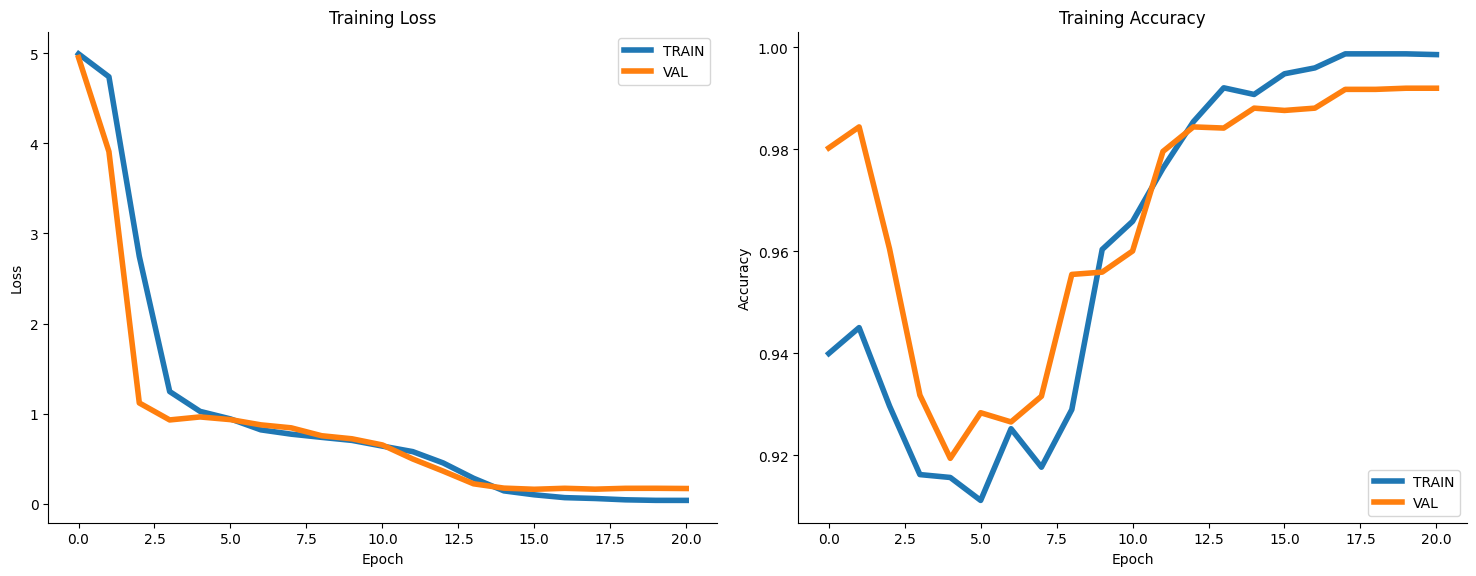

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))


sns.lineplot(data=history, x=range(len(history['loss'])), y=history['loss'],
             ax=axes[0], label='TRAIN', color='tab:blue', linewidth=4)

sns.lineplot(data=history, x=range(len(history['val_loss'])),
             y=history['val_loss'], ax=axes[0], label='VAL', color='tab:orange', linewidth=4)
axes[0].set_title('Training Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(loc='upper right')


sns.lineplot(data=history, x=range(len(history['accuracy'])), y=history['accuracy'],
             ax=axes[1], label='TRAIN', color='tab:blue', linewidth=4)
sns.lineplot(data=history, x=range(len(history['val_accuracy'])),
             y=history['val_accuracy'], ax=axes[1], label='VAL', color='tab:orange', linewidth=4)
axes[1].set_title('Training Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(loc='lower right')

sns.set(style="whitegrid")
sns.despine()
sns.set_context("notebook", font_scale=1.2)


plt.rcParams['lines.linewidth'] = 5
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.color'] = 'white'


plt.tight_layout()
plt.show()
plt.close()

# ***4. RESULT***

In [87]:
def sum_loss(embA, embB):
    return np.sum(abs(embA - embB))

In [281]:
sample = next(batch_generator(val_triplets, 1))

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(anchor),
    embedding(positive),
    embedding(negative)
)
dis_pos, dis_neg = siamese_model.predict([anchor, positive, negative])
print(f"Distance by model:\nPositive: {dis_pos[0]}, Negative: {dis_neg[0]}")


print(f"\nSum loss positive: {sum_loss(anchor_embedding, positive_embedding)}")
print(f"\nSum loss negative: {sum_loss(anchor_embedding, negative_embedding)}")

print(f"Sum loss positive & negative: {sum_loss(positive_embedding, negative_embedding)}")
for s in sample:
    play_sound(s)

1/1 [==============================] - 0s 21ms/step
Distance by model:
Positive: 0.7829392552375793, Negative: 16.108903884887695

Sum loss positive: 8.820842742919922

Sum loss negative: 39.782676696777344
Sum loss positive & negative: 48.603519439697266


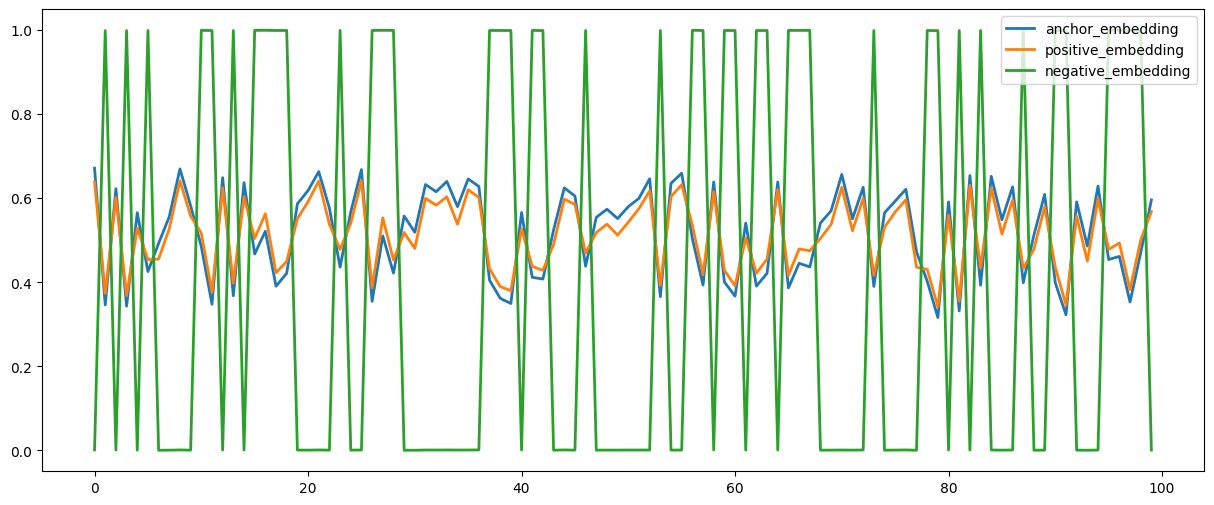

In [89]:
sns.reset_defaults()
embs = [anchor_embedding, positive_embedding, negative_embedding]
labels = ['anchor_embedding', 'positive_embedding', 'negative_embedding']
plt.subplots(figsize=(15, 6))
plt.rcParams['lines.linewidth'] = 2
for emb, label in zip(embs, labels):
    plt.plot(emb[0, :], label=label)
plt.legend(loc='upper right')
plt.show()

## ***4.1. DISTANCE DISTRIBUTION VISUALIZE***

In [282]:
def sumloss_visualize(type_triplets, type_name, threshold=None):
    pos_loss = []
    neg_loss = []

    for _ in tqdm(type_triplets):
        sample = next(batch_generator(type_triplets, 1))

        anchor, positive, negative = sample
        dis_pos, dis_neg = siamese_model.predict([anchor, positive, negative])

    # Lưu các giá trị sum loss vào một list để vẽ biểu đồ histogram
        pos_loss.append(dis_pos[0])
        neg_loss.append(dis_neg[0])



    fig = plt.figure(figsize=(15,10))
    axes = fig.subplot_mosaic("""AB
                                CC
                                """)

    plt.title('Distribution of Sum Loss')
    plt.xlabel(f'Sum Loss {type_name.title()}')
    plt.ylabel('Number of samples')

    sns.histplot(pos_loss, bins=10, kde=True, label="Positive", ax=axes["A"], color='blue');

    axes["A"].legend(loc='upper right')

    sns.histplot(neg_loss, bins=10, kde=True, label="Negative", ax=axes["B"], color='red');

    axes["B"].legend(loc='upper right')

    sns.histplot(pos_loss, bins=10, kde=True, label="Positive", ax=axes["C"],  color='blue')
    sns.histplot(neg_loss, bins=10, kde=True, label="Negative", ax=axes["C"],  color='red')

    axes["C"].legend(loc='upper right')

    if threshold is not None:
        axes["A"].axvline(x=threshold, color='r', linestyle='--')
        axes["B"].axvline(x=threshold, color='r', linestyle='--')
        axes["C"].axvline(x=threshold, color='r', linestyle='--')

    plt.tight_layout()
    plt.show()
    return pos_loss, neg_loss

  0%|          | 0/755 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 1/755 [00:00<01:18,  9.58it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 2/755 [00:00<01:16,  9.80it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 3/755 [00:00<01:16,  9.78it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 4/755 [00:00<01:16,  9.79it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 6/755 [00:00<01:12, 10.40it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 8/755 [00:00<01:13, 10.19it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 10/755 [00:00<01:12, 10.23it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 12/755 [00:01<01:11, 10.35it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 14/755 [00:01<01:10, 10.45it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 16/755 [00:01<01:05, 11.36it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 18/755 [00:01<01:00, 12.16it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 20/755 [00:01<00:57, 12.68it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 22/755 [00:01<00:55, 13.15it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 24/755 [00:02<00:53, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 26/755 [00:02<00:52, 13.78it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 28/755 [00:02<00:53, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 30/755 [00:02<00:52, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 32/755 [00:02<00:50, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 34/755 [00:02<00:51, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 36/755 [00:02<00:51, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 38/755 [00:03<00:50, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 40/755 [00:03<00:48, 14.64it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 42/755 [00:03<00:48, 14.68it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 44/755 [00:03<00:48, 14.58it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 46/755 [00:03<00:48, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 48/755 [00:03<00:47, 14.81it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 50/755 [00:03<00:46, 15.10it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 52/755 [00:03<00:47, 14.92it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 54/755 [00:04<00:47, 14.69it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 56/755 [00:04<00:47, 14.75it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 58/755 [00:04<00:47, 14.55it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 60/755 [00:04<00:47, 14.51it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 62/755 [00:04<00:47, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 64/755 [00:04<00:47, 14.44it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 66/755 [00:04<00:48, 14.27it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 68/755 [00:05<00:48, 14.26it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 70/755 [00:05<00:48, 14.25it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 72/755 [00:05<00:48, 14.18it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 74/755 [00:05<00:46, 14.63it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 76/755 [00:05<00:47, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 78/755 [00:05<00:47, 14.18it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 80/755 [00:05<00:47, 14.36it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 82/755 [00:06<00:46, 14.37it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 84/755 [00:06<00:46, 14.33it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 86/755 [00:06<00:46, 14.30it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 88/755 [00:06<00:46, 14.49it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 90/755 [00:06<00:46, 14.17it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 92/755 [00:06<00:46, 14.14it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 94/755 [00:07<01:19,  8.35it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 96/755 [00:07<01:09,  9.43it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 98/755 [00:07<01:02, 10.53it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 100/755 [00:07<00:56, 11.62it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 102/755 [00:07<00:53, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 104/755 [00:07<00:51, 12.73it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 106/755 [00:08<00:48, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 108/755 [00:08<00:46, 13.92it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 110/755 [00:08<00:46, 13.93it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 112/755 [00:08<00:45, 14.02it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 114/755 [00:08<00:44, 14.54it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 116/755 [00:08<00:43, 14.65it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 118/755 [00:08<00:45, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 120/755 [00:09<00:43, 14.58it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 122/755 [00:09<00:42, 14.83it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 124/755 [00:09<00:42, 14.71it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 126/755 [00:09<00:43, 14.43it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 128/755 [00:09<00:43, 14.44it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 130/755 [00:09<00:42, 14.63it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 132/755 [00:09<00:42, 14.67it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 134/755 [00:09<00:42, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 136/755 [00:10<00:41, 14.76it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 138/755 [00:10<00:41, 14.75it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 140/755 [00:10<00:41, 14.99it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 142/755 [00:10<00:42, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 144/755 [00:10<00:41, 14.72it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 146/755 [00:10<00:41, 14.79it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 148/755 [00:10<00:41, 14.76it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 150/755 [00:11<00:41, 14.71it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 152/755 [00:11<00:41, 14.63it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 154/755 [00:11<00:40, 14.75it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 156/755 [00:11<00:45, 13.13it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 158/755 [00:11<00:49, 12.02it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 160/755 [00:11<00:53, 11.17it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 162/755 [00:12<00:53, 11.03it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 164/755 [00:12<00:54, 10.79it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 166/755 [00:12<00:57, 10.18it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 168/755 [00:12<00:55, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 170/755 [00:12<00:56, 10.43it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 172/755 [00:13<00:56, 10.41it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 174/755 [00:13<00:58, 10.01it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 176/755 [00:13<00:57, 10.09it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 178/755 [00:13<00:56, 10.15it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 180/755 [00:13<00:55, 10.38it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 182/755 [00:14<00:55, 10.36it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 184/755 [00:14<00:55, 10.31it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 186/755 [00:14<00:55, 10.31it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 188/755 [00:14<00:55, 10.21it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 190/755 [00:14<00:56,  9.96it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 192/755 [00:15<00:55, 10.22it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 194/755 [00:15<00:53, 10.57it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 196/755 [00:15<00:53, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 198/755 [00:15<00:54, 10.27it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 200/755 [00:15<00:53, 10.29it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 202/755 [00:16<00:52, 10.55it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 204/755 [00:16<00:49, 11.09it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 206/755 [00:16<00:46, 11.90it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 208/755 [00:16<00:43, 12.46it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 210/755 [00:16<00:42, 12.94it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 212/755 [00:16<00:41, 13.22it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 214/755 [00:16<00:39, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 216/755 [00:17<00:39, 13.69it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 218/755 [00:17<00:37, 14.21it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 220/755 [00:17<00:36, 14.56it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 222/755 [00:17<00:37, 14.37it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 224/755 [00:17<00:37, 14.33it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 226/755 [00:17<00:36, 14.45it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 228/755 [00:17<00:36, 14.53it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 230/755 [00:17<00:36, 14.53it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 232/755 [00:18<00:35, 14.88it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 234/755 [00:18<00:34, 14.92it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 236/755 [00:18<00:35, 14.77it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 238/755 [00:18<00:35, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 240/755 [00:18<00:35, 14.68it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 242/755 [00:18<00:36, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 244/755 [00:18<00:35, 14.36it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 246/755 [00:19<00:35, 14.22it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 248/755 [00:19<00:36, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 250/755 [00:19<00:35, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 252/755 [00:19<00:35, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 254/755 [00:19<00:35, 14.21it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 256/755 [00:19<00:35, 13.99it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 258/755 [00:19<00:34, 14.35it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 260/755 [00:20<00:34, 14.50it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 262/755 [00:20<00:34, 14.43it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 264/755 [00:20<00:34, 14.20it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 266/755 [00:20<00:35, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 268/755 [00:20<00:34, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 270/755 [00:20<00:34, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 272/755 [00:20<00:34, 14.02it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 274/755 [00:21<00:33, 14.50it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 276/755 [00:21<00:32, 14.67it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 278/755 [00:21<00:33, 14.45it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 280/755 [00:21<00:32, 14.55it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 282/755 [00:21<00:32, 14.49it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 284/755 [00:21<00:32, 14.47it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 286/755 [00:21<00:33, 13.95it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 288/755 [00:22<00:33, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 290/755 [00:22<00:32, 14.09it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 292/755 [00:22<00:33, 13.92it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 294/755 [00:22<00:33, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 296/755 [00:22<00:33, 13.85it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 298/755 [00:22<00:32, 14.10it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 300/755 [00:22<00:32, 14.02it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 302/755 [00:23<00:32, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 304/755 [00:23<00:32, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 306/755 [00:23<00:32, 13.81it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 308/755 [00:23<00:32, 13.81it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 310/755 [00:23<00:31, 13.98it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 312/755 [00:23<00:31, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 314/755 [00:23<00:32, 13.62it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 316/755 [00:24<00:31, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 318/755 [00:24<00:30, 14.11it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 320/755 [00:24<00:31, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 322/755 [00:24<00:30, 14.22it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 324/755 [00:24<00:30, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 326/755 [00:24<00:29, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 328/755 [00:24<00:30, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 330/755 [00:25<00:30, 14.04it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 332/755 [00:25<00:29, 14.33it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 334/755 [00:25<00:29, 14.50it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 336/755 [00:25<00:29, 14.44it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 338/755 [00:25<00:29, 14.12it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 340/755 [00:25<00:29, 14.18it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 342/755 [00:25<00:30, 13.42it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 344/755 [00:26<00:30, 13.50it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 346/755 [00:26<00:31, 12.81it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 348/755 [00:26<00:34, 11.88it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 350/755 [00:26<00:34, 11.70it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 352/755 [00:26<00:35, 11.38it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 354/755 [00:26<00:36, 11.07it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 356/755 [00:27<00:35, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 358/755 [00:27<00:34, 11.40it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 360/755 [00:27<00:35, 11.22it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 362/755 [00:27<00:35, 10.98it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 364/755 [00:27<00:36, 10.81it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 366/755 [00:28<00:36, 10.66it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 368/755 [00:28<00:37, 10.38it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 370/755 [00:28<00:37, 10.32it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 372/755 [00:28<00:35, 10.85it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 374/755 [00:28<00:35, 10.83it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 376/755 [00:29<00:36, 10.25it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 378/755 [00:29<00:36, 10.24it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 380/755 [00:29<00:36, 10.19it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 382/755 [00:29<00:35, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 384/755 [00:29<00:36, 10.21it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 386/755 [00:30<00:35, 10.37it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 388/755 [00:30<00:35, 10.40it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 390/755 [00:30<00:34, 10.50it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 392/755 [00:30<00:34, 10.42it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 394/755 [00:30<00:34, 10.41it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 396/755 [00:30<00:34, 10.45it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 398/755 [00:31<00:34, 10.37it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 400/755 [00:31<00:31, 11.16it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 402/755 [00:31<00:29, 11.85it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 404/755 [00:31<00:28, 12.34it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 406/755 [00:31<00:27, 12.56it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 408/755 [00:31<00:27, 12.53it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 410/755 [00:32<00:27, 12.48it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 412/755 [00:32<00:26, 12.79it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 414/755 [00:32<00:25, 13.27it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 416/755 [00:32<00:26, 13.03it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 418/755 [00:32<00:25, 13.34it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 420/755 [00:32<00:25, 13.07it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 422/755 [00:32<00:24, 13.41it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 424/755 [00:33<00:24, 13.44it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 426/755 [00:33<00:23, 13.83it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 428/755 [00:33<00:23, 13.95it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 430/755 [00:33<00:23, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 432/755 [00:33<00:23, 13.75it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 434/755 [00:33<00:22, 14.05it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 436/755 [00:33<00:22, 13.98it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 438/755 [00:34<00:22, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 440/755 [00:34<00:22, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 442/755 [00:34<00:22, 13.73it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 444/755 [00:34<00:22, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 446/755 [00:34<00:22, 13.78it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 448/755 [00:34<00:22, 13.51it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 450/755 [00:35<00:22, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 452/755 [00:35<00:22, 13.68it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 454/755 [00:35<00:21, 13.77it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 456/755 [00:35<00:21, 13.87it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 458/755 [00:35<00:21, 13.98it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 460/755 [00:35<00:20, 14.08it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 462/755 [00:35<00:20, 14.12it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 464/755 [00:36<00:21, 13.82it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 466/755 [00:36<00:21, 13.64it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 468/755 [00:36<00:21, 13.16it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 470/755 [00:36<00:20, 13.58it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 472/755 [00:36<00:20, 13.50it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 474/755 [00:36<00:20, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 476/755 [00:36<00:20, 13.77it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 478/755 [00:37<00:19, 13.91it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 480/755 [00:37<00:19, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 482/755 [00:37<00:20, 13.11it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 484/755 [00:37<00:20, 13.39it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 486/755 [00:37<00:19, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 488/755 [00:37<00:19, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 490/755 [00:37<00:19, 13.62it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 492/755 [00:38<00:18, 13.97it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 494/755 [00:38<00:18, 14.19it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 496/755 [00:38<00:19, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 498/755 [00:38<00:18, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 500/755 [00:38<00:18, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 502/755 [00:38<00:18, 13.96it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 504/755 [00:38<00:18, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 506/755 [00:39<00:17, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 508/755 [00:39<00:17, 14.16it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 510/755 [00:39<00:17, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 512/755 [00:39<00:17, 13.87it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 514/755 [00:39<00:17, 13.84it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 516/755 [00:39<00:17, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 518/755 [00:39<00:17, 13.85it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 520/755 [00:40<00:16, 13.91it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 522/755 [00:40<00:16, 13.95it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 524/755 [00:40<00:16, 13.74it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 526/755 [00:40<00:16, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 528/755 [00:40<00:16, 14.03it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 530/755 [00:40<00:16, 14.01it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 532/755 [00:40<00:16, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 534/755 [00:41<00:15, 14.01it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 536/755 [00:41<00:15, 13.76it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 538/755 [00:41<00:18, 12.04it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 540/755 [00:41<00:18, 11.63it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 542/755 [00:41<00:19, 11.05it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 544/755 [00:42<00:19, 11.04it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 546/755 [00:42<00:19, 10.85it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 548/755 [00:42<00:19, 10.53it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 550/755 [00:42<00:19, 10.36it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 552/755 [00:42<00:19, 10.44it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 554/755 [00:43<00:19, 10.18it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 556/755 [00:43<00:19, 10.27it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 558/755 [00:43<00:19, 10.14it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 560/755 [00:43<00:19, 10.15it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 562/755 [00:43<00:18, 10.31it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 564/755 [00:43<00:18, 10.32it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 566/755 [00:44<00:18, 10.03it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 568/755 [00:44<00:18,  9.96it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 569/755 [00:44<00:18,  9.92it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 570/755 [00:44<00:18,  9.74it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 572/755 [00:44<00:17, 10.31it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 574/755 [00:44<00:17, 10.38it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 576/755 [00:45<00:16, 10.54it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 578/755 [00:45<00:16, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 580/755 [00:45<00:17, 10.06it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 582/755 [00:45<00:16, 10.49it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 584/755 [00:45<00:16, 10.18it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 586/755 [00:46<00:16, 10.28it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 588/755 [00:46<00:16, 10.43it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 590/755 [00:46<00:14, 11.25it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 592/755 [00:46<00:14, 11.64it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 594/755 [00:46<00:13, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 596/755 [00:46<00:12, 12.69it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 598/755 [00:47<00:12, 13.04it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 600/755 [00:47<00:11, 13.18it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 602/755 [00:47<00:11, 13.18it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 604/755 [00:47<00:11, 13.33it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 606/755 [00:47<00:11, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 608/755 [00:47<00:11, 13.35it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 610/755 [00:47<00:10, 13.61it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 612/755 [00:48<00:10, 13.59it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 614/755 [00:48<00:10, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 616/755 [00:48<00:10, 13.79it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 618/755 [00:48<00:10, 13.68it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 620/755 [00:48<00:09, 13.63it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 622/755 [00:48<00:09, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 624/755 [00:48<00:09, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 626/755 [00:49<00:09, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 628/755 [00:49<00:09, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 630/755 [00:49<00:08, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 632/755 [00:49<00:09, 13.64it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 634/755 [00:49<00:08, 13.57it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 636/755 [00:49<00:08, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 638/755 [00:49<00:08, 13.71it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 640/755 [00:50<00:08, 13.81it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 642/755 [00:50<00:08, 13.69it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 644/755 [00:50<00:08, 13.31it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 646/755 [00:50<00:08, 13.27it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 648/755 [00:50<00:08, 13.15it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 650/755 [00:50<00:07, 13.19it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 652/755 [00:51<00:07, 13.66it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 654/755 [00:51<00:07, 14.16it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 656/755 [00:51<00:07, 13.99it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 658/755 [00:51<00:07, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 660/755 [00:51<00:06, 13.62it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 662/755 [00:51<00:06, 13.75it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 664/755 [00:51<00:06, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 666/755 [00:52<00:06, 13.34it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 668/755 [00:52<00:06, 13.51it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 670/755 [00:52<00:06, 13.64it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 672/755 [00:52<00:06, 13.53it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 674/755 [00:52<00:05, 13.67it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 676/755 [00:52<00:05, 13.57it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 678/755 [00:52<00:05, 13.70it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 680/755 [00:53<00:05, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 682/755 [00:53<00:05, 13.99it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 684/755 [00:53<00:05, 14.03it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 686/755 [00:53<00:04, 14.12it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 688/755 [00:53<00:04, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 690/755 [00:53<00:04, 13.84it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 692/755 [00:53<00:04, 13.83it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 694/755 [00:54<00:04, 14.08it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 696/755 [00:54<00:04, 14.11it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 698/755 [00:54<00:04, 13.73it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 700/755 [00:54<00:04, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 702/755 [00:54<00:03, 13.77it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 704/755 [00:54<00:03, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 706/755 [00:54<00:03, 13.28it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 708/755 [00:55<00:03, 13.41it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 710/755 [00:55<00:03, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 712/755 [00:55<00:03, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 714/755 [00:55<00:03, 13.00it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 716/755 [00:55<00:02, 13.47it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 718/755 [00:55<00:02, 13.02it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 720/755 [00:56<00:02, 13.10it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 722/755 [00:56<00:02, 13.00it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 724/755 [00:56<00:02, 13.18it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 726/755 [00:56<00:02, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 728/755 [00:56<00:02, 11.53it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 730/755 [00:56<00:02, 10.82it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 732/755 [00:57<00:02, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 734/755 [00:57<00:02, 10.37it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 736/755 [00:57<00:01, 10.38it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 738/755 [00:57<00:01, 10.00it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 740/755 [00:57<00:01,  9.88it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 741/755 [00:58<00:01,  9.82it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 742/755 [00:58<00:01,  9.80it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 744/755 [00:58<00:01, 10.04it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 746/755 [00:58<00:00,  9.40it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 748/755 [00:58<00:00,  9.69it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 749/755 [00:58<00:00,  9.61it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 750/755 [00:58<00:00,  9.55it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 752/755 [00:59<00:00,  9.88it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 753/755 [00:59<00:00,  9.59it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 754/755 [00:59<00:00,  9.47it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 755/755 [00:59<00:00, 12.68it/s]


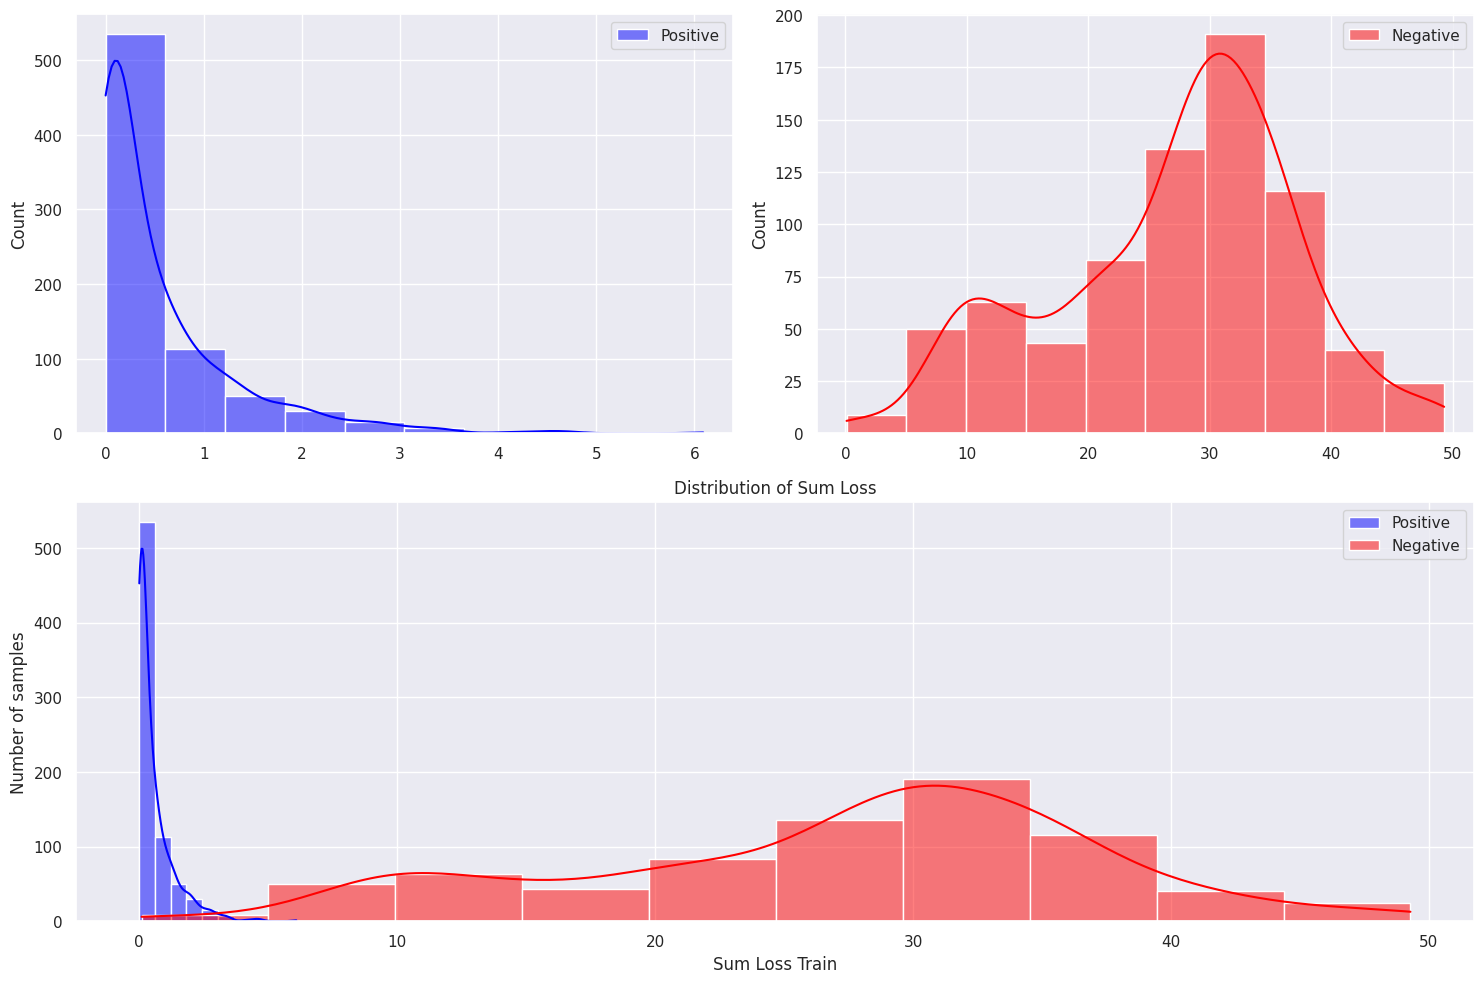

In [283]:
pos_loss, neg_loss = sumloss_visualize(train_triplets, type_name='Train')

  0%|          | 0/249 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 2/249 [00:00<00:16, 15.02it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 4/249 [00:00<00:16, 14.97it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 6/249 [00:00<00:16, 14.98it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 8/249 [00:00<00:16, 14.76it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 10/249 [00:00<00:16, 14.88it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 12/249 [00:00<00:16, 14.67it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 14/249 [00:00<00:15, 14.97it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 16/249 [00:01<00:15, 14.89it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 18/249 [00:01<00:15, 14.92it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 20/249 [00:01<00:15, 14.69it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 22/249 [00:01<00:15, 14.60it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 24/249 [00:01<00:15, 14.77it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 26/249 [00:01<00:15, 14.83it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 28/249 [00:01<00:14, 15.09it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 30/249 [00:02<00:14, 15.13it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 32/249 [00:02<00:14, 14.74it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 34/249 [00:02<00:14, 14.95it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 36/249 [00:02<00:14, 14.89it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 38/249 [00:02<00:14, 14.80it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 40/249 [00:02<00:14, 14.30it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 42/249 [00:02<00:14, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 44/249 [00:02<00:14, 14.60it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 46/249 [00:03<00:13, 14.60it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 48/249 [00:03<00:14, 14.29it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 50/249 [00:03<00:14, 14.15it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 52/249 [00:03<00:14, 13.78it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 54/249 [00:03<00:14, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 56/249 [00:03<00:14, 13.21it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 58/249 [00:04<00:14, 13.49it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 60/249 [00:04<00:13, 13.90it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 62/249 [00:04<00:13, 14.19it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 64/249 [00:04<00:13, 14.20it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 66/249 [00:04<00:12, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 68/249 [00:04<00:12, 14.65it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 70/249 [00:04<00:11, 14.96it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 72/249 [00:04<00:11, 15.00it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 74/249 [00:05<00:11, 15.04it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 76/249 [00:05<00:11, 15.16it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 78/249 [00:05<00:11, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 80/249 [00:05<00:11, 14.76it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 82/249 [00:05<00:11, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 84/249 [00:05<00:11, 14.70it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 86/249 [00:05<00:10, 14.89it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 88/249 [00:06<00:10, 14.99it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 90/249 [00:06<00:10, 14.78it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 92/249 [00:06<00:10, 14.91it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 94/249 [00:06<00:10, 14.76it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 96/249 [00:06<00:10, 14.81it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 98/249 [00:06<00:10, 14.72it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 100/249 [00:06<00:10, 14.59it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 102/249 [00:06<00:09, 14.96it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 104/249 [00:07<00:09, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 106/249 [00:07<00:09, 14.71it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 108/249 [00:07<00:09, 14.29it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 110/249 [00:07<00:10, 13.67it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 112/249 [00:07<00:10, 12.46it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 114/249 [00:07<00:11, 11.73it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 116/249 [00:08<00:11, 11.27it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 118/249 [00:08<00:12, 10.67it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 120/249 [00:08<00:12, 10.51it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 122/249 [00:08<00:12, 10.46it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 124/249 [00:08<00:11, 10.68it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 126/249 [00:09<00:11, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 128/249 [00:09<00:11, 10.33it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 130/249 [00:09<00:12,  9.80it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 132/249 [00:09<00:11, 10.33it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 134/249 [00:09<00:11, 10.33it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 136/249 [00:10<00:11, 10.20it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 138/249 [00:10<00:10, 10.25it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 140/249 [00:10<00:10, 10.00it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 142/249 [00:10<00:10, 10.08it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 144/249 [00:10<00:10,  9.98it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 146/249 [00:11<00:10, 10.18it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 148/249 [00:11<00:09, 10.40it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 150/249 [00:11<00:09, 10.56it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 152/249 [00:11<00:09, 10.48it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 154/249 [00:11<00:08, 10.66it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 156/249 [00:12<00:08, 10.83it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 158/249 [00:12<00:08, 11.10it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 160/249 [00:12<00:07, 11.94it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 162/249 [00:12<00:06, 12.59it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 164/249 [00:12<00:06, 13.18it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 166/249 [00:12<00:06, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 168/249 [00:12<00:05, 13.57it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 170/249 [00:13<00:05, 13.88it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 172/249 [00:13<00:05, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 174/249 [00:13<00:05, 14.45it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 176/249 [00:13<00:05, 14.02it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 178/249 [00:13<00:05, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 180/249 [00:13<00:04, 14.23it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 182/249 [00:13<00:04, 14.03it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 184/249 [00:14<00:04, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 186/249 [00:14<00:04, 13.99it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 188/249 [00:14<00:04, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 190/249 [00:14<00:04, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 192/249 [00:14<00:03, 14.30it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 194/249 [00:14<00:03, 13.97it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 196/249 [00:14<00:03, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 198/249 [00:14<00:03, 14.27it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 200/249 [00:15<00:03, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 202/249 [00:15<00:03, 13.89it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 204/249 [00:15<00:03, 13.98it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 206/249 [00:15<00:02, 14.41it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 208/249 [00:15<00:02, 14.17it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 210/249 [00:15<00:02, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 212/249 [00:15<00:02, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 214/249 [00:16<00:02, 14.21it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 216/249 [00:16<00:02, 14.41it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 218/249 [00:16<00:02, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 220/249 [00:16<00:01, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 222/249 [00:16<00:01, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 224/249 [00:16<00:01, 14.30it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 226/249 [00:16<00:01, 13.94it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 228/249 [00:17<00:01, 14.13it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 230/249 [00:17<00:01, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 232/249 [00:17<00:01, 14.24it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 234/249 [00:17<00:01, 14.22it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 236/249 [00:17<00:00, 14.28it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 238/249 [00:17<00:00, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 240/249 [00:17<00:00, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 242/249 [00:18<00:00, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 244/249 [00:18<00:00, 13.89it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 246/249 [00:18<00:00, 14.02it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 248/249 [00:18<00:00, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 249/249 [00:18<00:00, 13.38it/s]


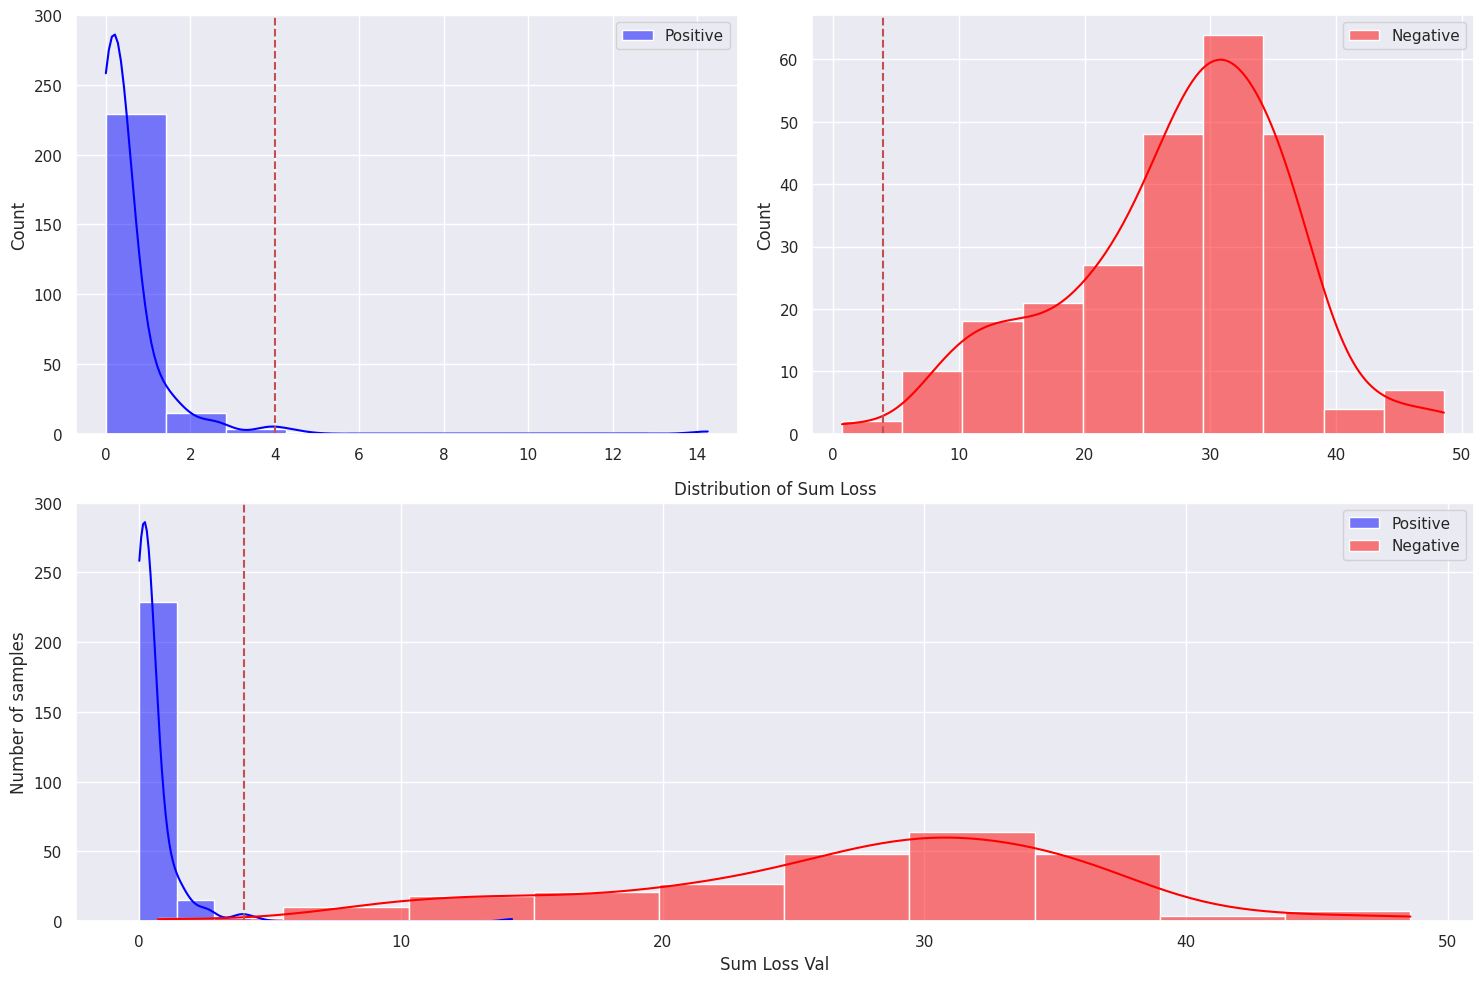

In [284]:
pos_loss, neg_loss = sumloss_visualize(val_triplets, type_name='Val', threshold=4)

  0%|          | 0/124 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 2/124 [00:00<00:08, 14.80it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 4/124 [00:00<00:08, 14.85it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 6/124 [00:00<00:08, 14.49it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 8/124 [00:00<00:08, 14.20it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 10/124 [00:00<00:08, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 12/124 [00:00<00:07, 14.34it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 14/124 [00:00<00:07, 14.56it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 16/124 [00:01<00:07, 14.37it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 18/124 [00:01<00:07, 13.48it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 20/124 [00:01<00:07, 13.48it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 22/124 [00:01<00:07, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 24/124 [00:01<00:07, 13.77it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 26/124 [00:01<00:07, 13.75it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 28/124 [00:01<00:06, 14.27it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 30/124 [00:02<00:06, 14.49it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 32/124 [00:02<00:07, 12.56it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 34/124 [00:02<00:07, 11.62it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 36/124 [00:02<00:07, 11.19it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 38/124 [00:02<00:07, 11.04it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 40/124 [00:03<00:07, 10.91it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 42/124 [00:03<00:07, 10.73it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 44/124 [00:03<00:07, 10.48it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 46/124 [00:03<00:07, 10.26it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 48/124 [00:03<00:07, 10.41it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 50/124 [00:04<00:07, 10.16it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 52/124 [00:04<00:07, 10.24it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 54/124 [00:04<00:06, 10.10it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 56/124 [00:04<00:06, 10.10it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 58/124 [00:04<00:06, 10.00it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 60/124 [00:05<00:06, 10.04it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 62/124 [00:05<00:06,  9.92it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 64/124 [00:05<00:06,  9.83it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 65/124 [00:05<00:05,  9.84it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 66/124 [00:05<00:05,  9.84it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 68/124 [00:05<00:05, 10.20it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 70/124 [00:06<00:05, 10.43it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 72/124 [00:06<00:05, 10.39it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 74/124 [00:06<00:05,  9.97it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 76/124 [00:06<00:04,  9.99it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 78/124 [00:06<00:04, 10.40it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 80/124 [00:06<00:03, 11.49it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 82/124 [00:07<00:03, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 84/124 [00:07<00:03, 12.84it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 86/124 [00:07<00:02, 13.33it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 88/124 [00:07<00:02, 13.61it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 90/124 [00:07<00:02, 13.44it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 92/124 [00:07<00:02, 13.70it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 94/124 [00:07<00:02, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 96/124 [00:08<00:02, 13.67it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 98/124 [00:08<00:01, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 100/124 [00:08<00:01, 14.09it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 102/124 [00:08<00:01, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 104/124 [00:08<00:01, 14.22it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 106/124 [00:08<00:01, 13.98it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 108/124 [00:08<00:01, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 110/124 [00:09<00:00, 14.43it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 112/124 [00:09<00:00, 14.55it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 114/124 [00:09<00:00, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 116/124 [00:09<00:00, 14.46it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 118/124 [00:09<00:00, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 120/124 [00:09<00:00, 14.33it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 122/124 [00:10<00:00,  6.40it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 124/124 [00:10<00:00, 11.59it/s]


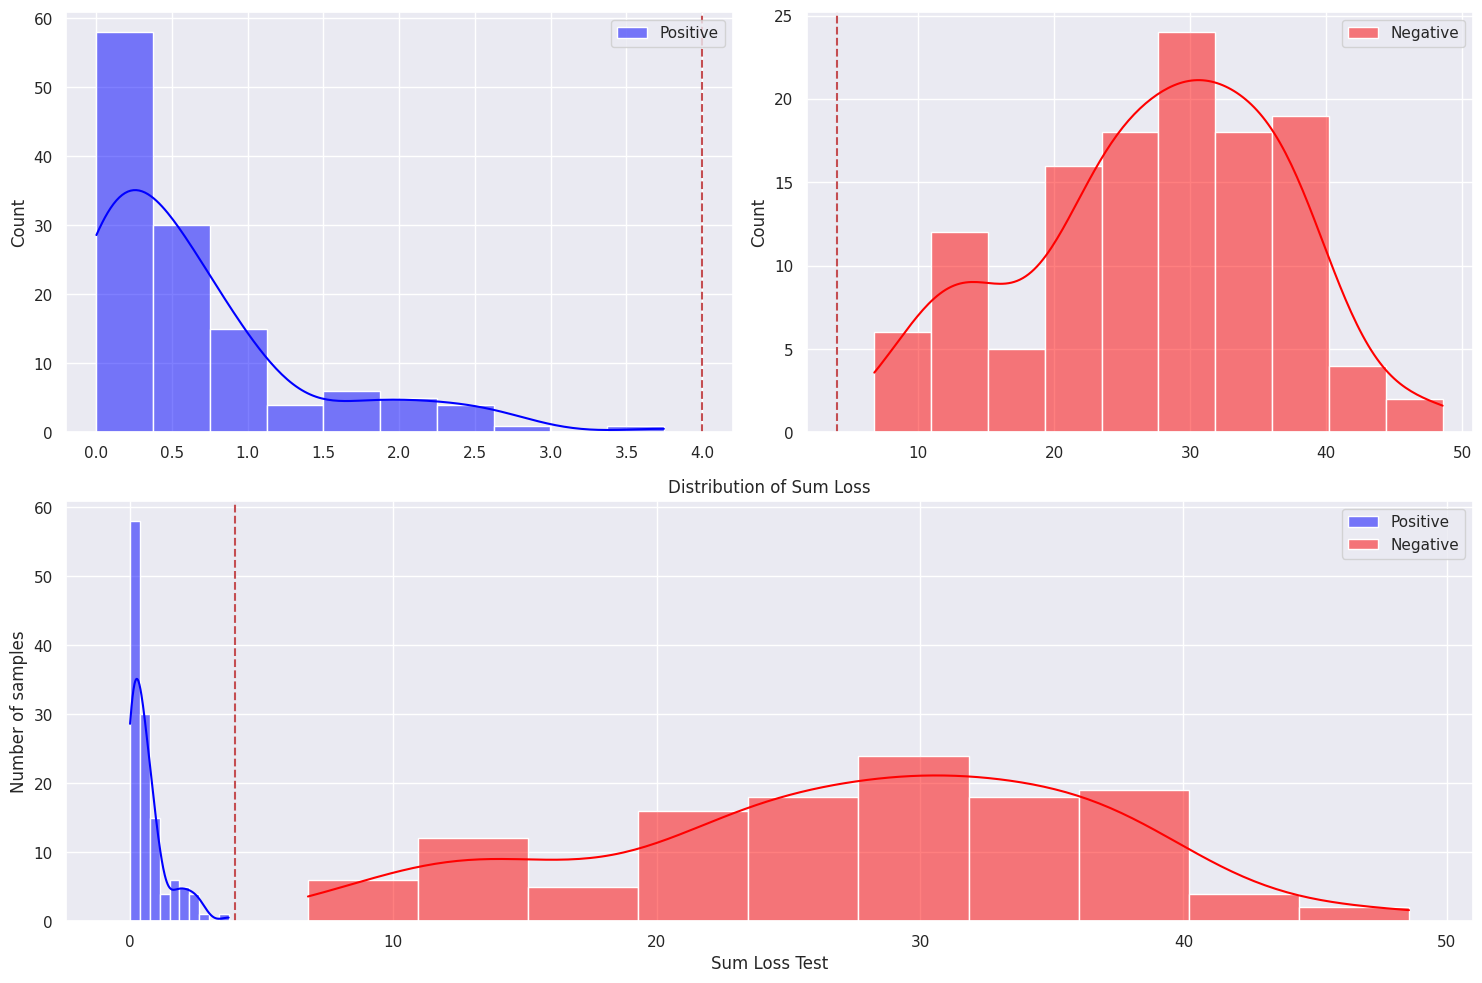

In [285]:
pos_loss, neg_loss = sumloss_visualize(test_triplets, type_name='Test', threshold=4)

In [287]:
correct_pos = sum(loss <= 4 for loss in pos_loss)
print(f'Correct positive predictions: {correct_pos}/{len(pos_loss)}')

correct_neg = sum(loss >= 4 for loss in neg_loss)
print(f'Correct negative predictions: {correct_neg}/{len(neg_loss)}')

Correct positive predictions: 124/124
Correct negative predictions: 124/124


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       124
         1.0       1.00      1.00      1.00       124

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248




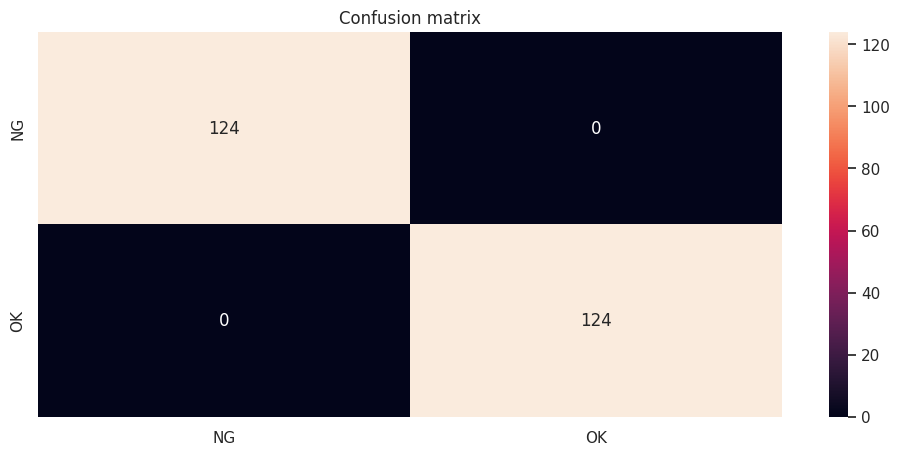

In [289]:
class_label = {0: "NG", 1: "OK"}
pred = np.array([1 if loss <= 4 else 0 for loss in pos_loss] + [0 if loss >= 4 else 1 for loss in neg_loss])
true = np.concatenate((np.ones(len(pos_loss)), np.zeros(len(neg_loss))))
plt.figure(figsize=(12, 5))
cf_matrix3 = confusion_matrix(true, pred)
plt.title("Confusion matrix")
sns.set(rc={'figure.figsize': (12, 6)})
sns.heatmap(cf_matrix3, annot=True, fmt="d",
            xticklabels={0: 'NG', 1: 'OK'}.values(),
            yticklabels={0: 'NG', 1: 'OK'}.values())

print(classification_report(true, pred))
print()
plt.show()